In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

from src.utils.config import load_config
from src.utils.visualize import mask_to_color_image

In [2]:
config = load_config('../configs/data/naver.yml')

In [3]:
# Extract values from config
ROOT_DIR = config['data']['dataset_path']
TRAIN_PATH = f"../{os.path.join(ROOT_DIR, 'train')}"
VAL_PATH = f"../{os.path.join(ROOT_DIR, 'val')}"
TEST_PATH = f"../{os.path.join(ROOT_DIR, 'test')}"

color_map = config['data']['color_map']
label_names = config['data']['labels']

color_hex_map = { k: '#{:02x}{:02x}{:02x}'.format(*v) for k, v in color_map.items() }

In [4]:
print("Train dataset size: {}".format(len(os.listdir(os.path.join(TRAIN_PATH, "images")))))
print("Val dataset size: {}".format(len(os.listdir(os.path.join(VAL_PATH, "images")))))
print("Test dataset size: {}".format(len(os.listdir(os.path.join(TEST_PATH,"images")))))

Train dataset size: 4390
Val dataset size: 1704
Test dataset size: 1707


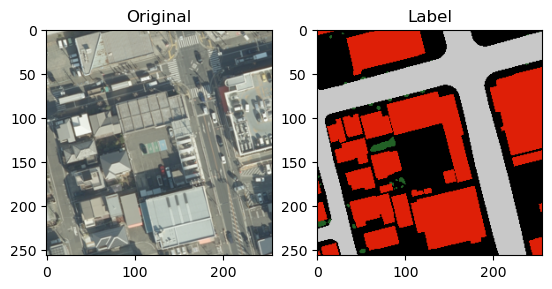

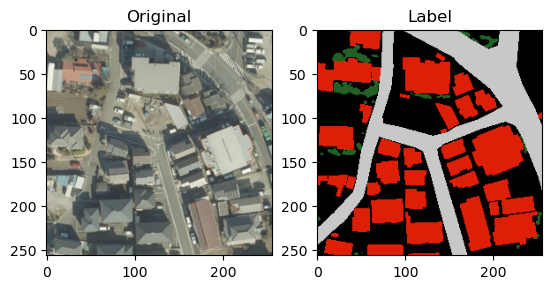

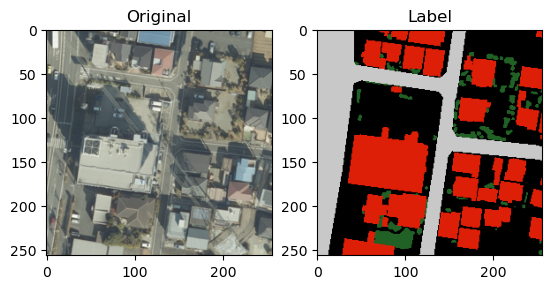

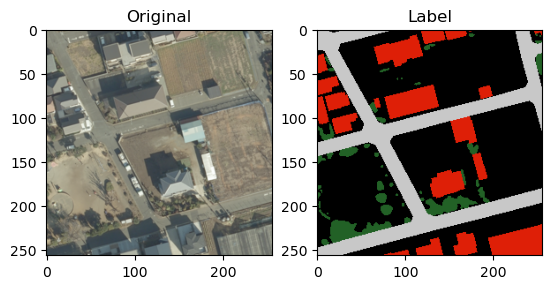

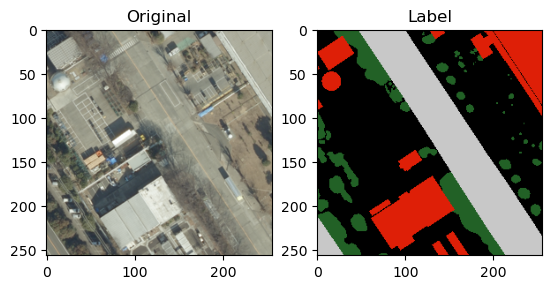

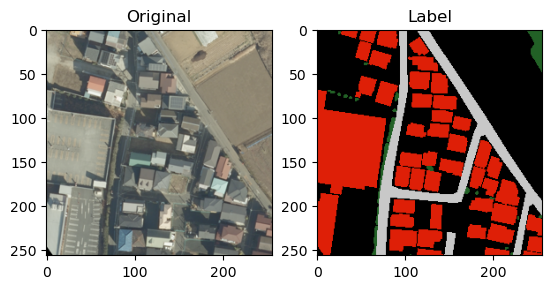

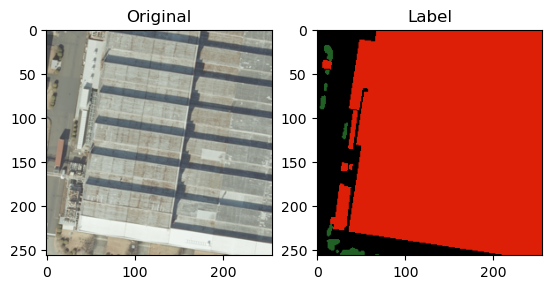

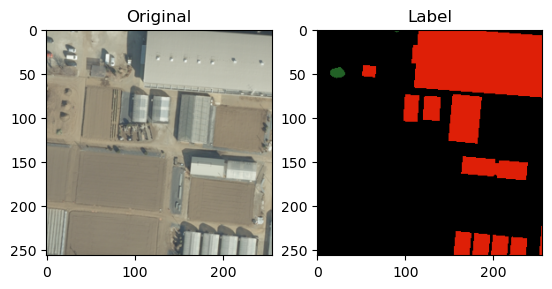

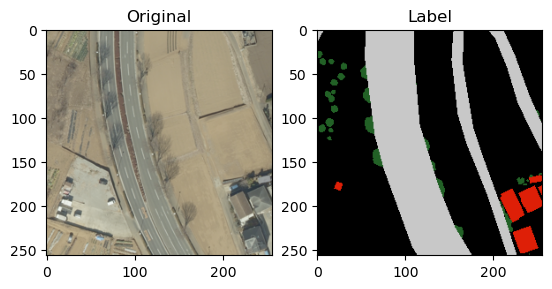

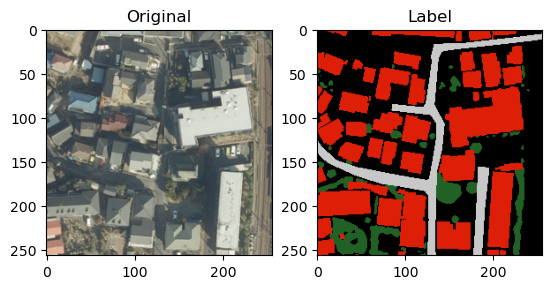

In [5]:
TRAIN_IMAGE_PATH = os.path.join(TRAIN_PATH, "images")
TRAIN_LABEL_PATH = os.path.join(TRAIN_PATH, "labels")
VAL_IMAGE_PATH = os.path.join(VAL_PATH, "images")
VAL_LABEL_PATH = os.path.join(VAL_PATH, "labels")
TEST_IMAGE_PATH = os.path.join(TEST_PATH, "images")
TEST_LABEL_PATH = os.path.join(TEST_PATH, "labels")

# 10 random train images with corresponding masks
random_images = random.sample(os.listdir(TRAIN_IMAGE_PATH), 10)

for subdir in random_images:
    image_path = os.path.join(TRAIN_IMAGE_PATH, subdir)
    mask_path = os.path.join(TRAIN_LABEL_PATH, subdir)
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Label")
    plt.imshow(mask_to_color_image(mask, color_map))

    plt.show()

Label-wise Pixel Count and Percentage:
Label: 0 - Background, Pixels: 245701716, Percentage: 48.06%
Label: 1 - Building, Pixels: 110790139, Percentage: 21.67%
Label: 2 - Road, Pixels: 62771359, Percentage: 12.28%
Label: 3 - Tree, Pixels: 59241302, Percentage: 11.59%
Label: 4 - Water, Pixels: 32741820, Percentage: 6.40%


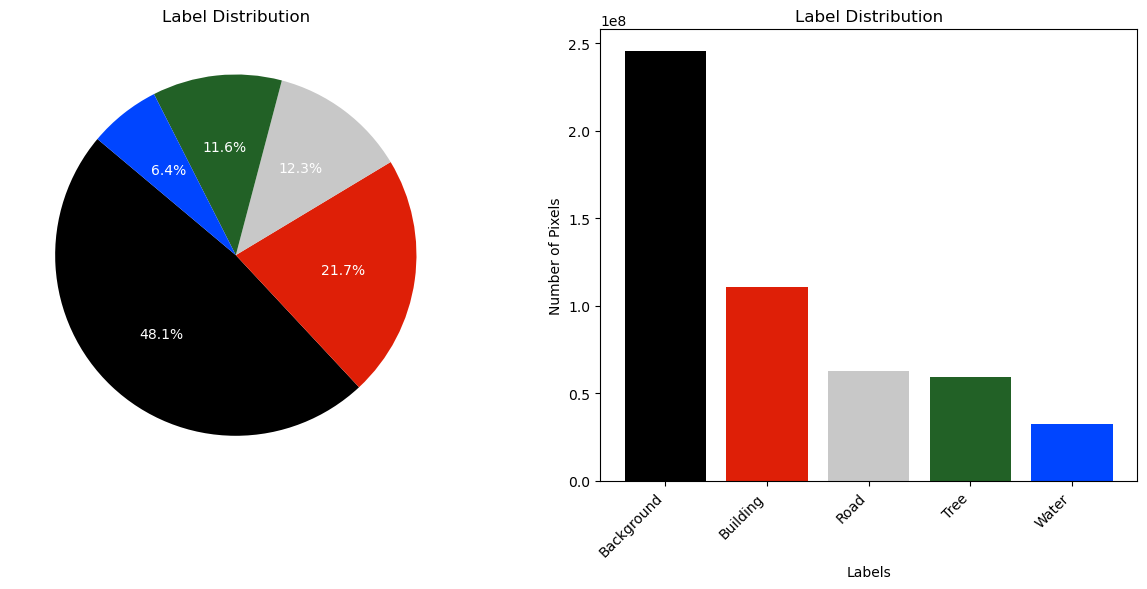

In [24]:
label_counts = {}

for subdir in os.listdir(os.path.join(TRAIN_PATH, "labels")):
    mask_path = os.path.join(TRAIN_LABEL_PATH, subdir)
    mask = cv2.imread(mask_path, 0)
    unique_labels, counts = np.unique(mask, return_counts=True)
    for label, count in zip(unique_labels, counts):
        if label in label_counts:
            label_counts[label] += count
        else:
            label_counts[label] = count

for subdir in os.listdir(os.path.join(VAL_PATH, "labels")):
    mask_path = os.path.join(VAL_LABEL_PATH, subdir)
    mask = cv2.imread(mask_path, 0)
    unique_labels, counts = np.unique(mask, return_counts=True)

    for label, count in zip(unique_labels, counts):
        if label in label_counts:
            label_counts[label] += count
        else:
            label_counts[label] = count

for subdir in os.listdir(os.path.join(TEST_PATH, "labels")):
    mask_path = os.path.join(TEST_LABEL_PATH, subdir)
    mask = cv2.imread(mask_path, 0)
    unique_labels, counts = np.unique(mask, return_counts=True)

    for label, count in zip(unique_labels, counts):
        if label in label_counts:
            label_counts[label] += count
        else:
            label_counts[label] = count


df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

df['Label Name'] = df['Label'].map(label_names)

df['Color'] = df['Label'].map(color_hex_map)

total_pixels = df['Count'].sum()

df['Percentage'] = (df['Count'] / total_pixels) * 100

df_sorted = df.sort_values(by='Count', ascending=False)

print("Label-wise Pixel Count and Percentage:")
for _, row in df_sorted.iterrows():
    print(f"Label: {next(key for key, value in label_names.items() if value == row['Label Name'])} - {row['Label Name']}, Pixels: {row['Count']}, Percentage: {row['Percentage']:.2f}%")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(df_sorted['Count'], labels=df_sorted['Label Name'], colors=df_sorted['Color'], textprops={'color': 'white'},autopct='%1.1f%%', startangle=140)
plt.title("Label Distribution")

plt.subplot(1, 2, 2)
plt.bar(df_sorted['Label Name'], df_sorted['Count'], color=df_sorted['Color'])
plt.xlabel('Labels')
plt.ylabel('Number of Pixels')
plt.title("Label Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
from scipy.ndimage import label
import os
import cv2
import numpy as np
from collections import defaultdict

segment_counts = defaultdict(int)  # {class_id: segment_count}

def count_segments_per_class(mask):
    class_segments = {}
    unique_labels = np.unique(mask)
    for label_id in unique_labels:
        if label_id == 0:
            continue  # optionally skip background
        binary_mask = (mask == label_id).astype(np.uint8)
        _, num = label(binary_mask)
        class_segments[label_id] = num
    return class_segments

# Combine all dataset label paths
ALL_LABEL_PATHS = [TRAIN_LABEL_PATH, VAL_LABEL_PATH, TEST_LABEL_PATH]

for path in ALL_LABEL_PATHS:
    for filename in os.listdir(path):
        mask_path = os.path.join(path, filename)
        mask = cv2.imread(mask_path, 0)
        if mask is not None:
            per_class_segments = count_segments_per_class(mask)
            for label_id, count in per_class_segments.items():
                segment_counts[label_id] += count

# Print results
print("Segment count per class:")
for label_id, count in sorted(segment_counts.items()):
    label_name = label_names.get(label_id, "Unknown")
    print(f"Label ID {label_id} ({label_name}): {count} segments")


Segment count per class:
Label ID 1 (Building): 173744 segments
Label ID 2 (Road): 13144 segments
Label ID 3 (Tree): 281449 segments
Label ID 4 (Water): 1661 segments
